Tutorial
===========

In [1]:
import networkx as nx
from networkx.drawing.nx_pydot import write_dot
import matplotlib.pyplot as plt

G=nx.Graph()
G.add_node(1)
G.add_nodes_from([2,3])
G.number_of_nodes()


3

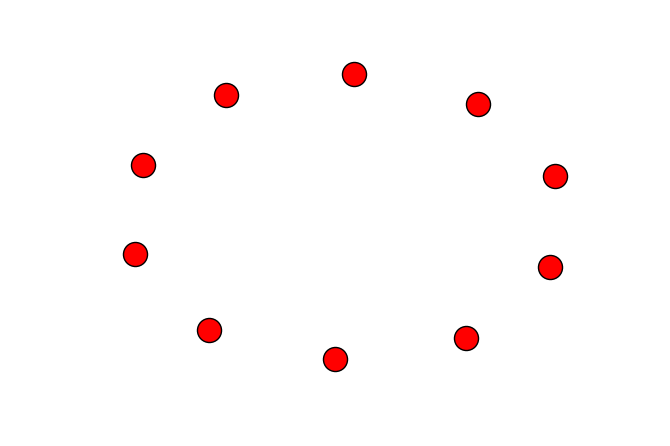

In [2]:
# Use path_graph
G.clear()
G = nx.Graph()
H = nx.path_graph(10)
G.add_nodes_from(H)

nx.draw(G)
plt.show()

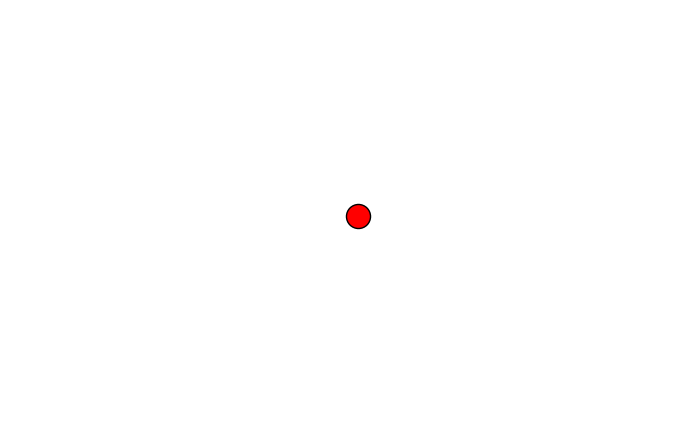

In [3]:
# Use path_graph, adding as node
G.clear()
G = nx.Graph()
H = nx.path_graph(10)
G.add_node(H)

nx.draw(G)
plt.show()

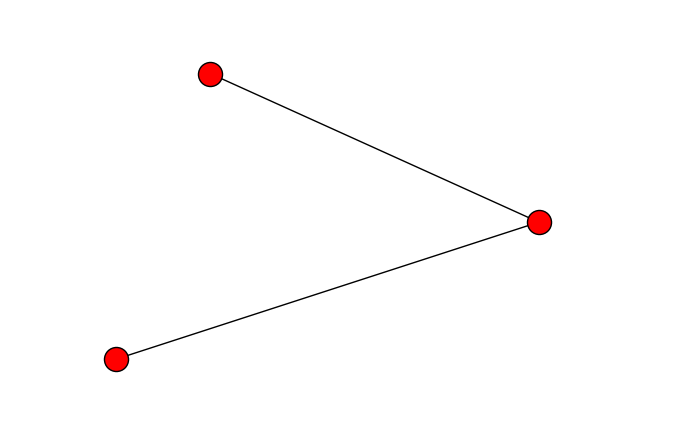

In [4]:
# Add edges
G.clear()
G.add_nodes_from([1,3])
G.add_edge(1,2)
e = (2,3)
G.add_edge(*e)
nx.draw(G)
plt.show()

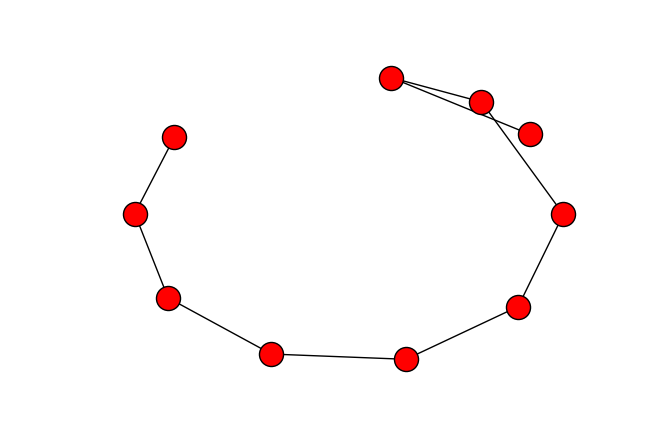

In [5]:
# Add edges from ebunch
G.clear()
G.add_edges_from(H.edges())
nx.draw(G)
plt.show()

In [6]:
G.number_of_nodes()

10

In [7]:
G.number_of_edges()

9

In [8]:
G.add_node("carne")
G.add_nodes_from("sangre")
G.nodes()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'a', 'n', 'e', 'r', 'carne', 's', 'g']

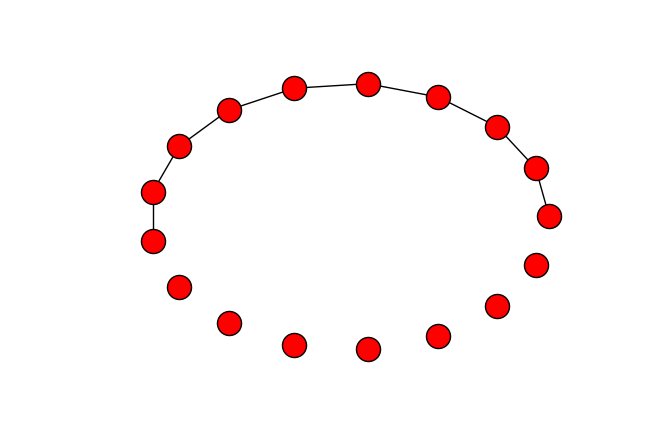

In [9]:
nx.draw_circular(G)
plt.show()

Graph generation
=====================

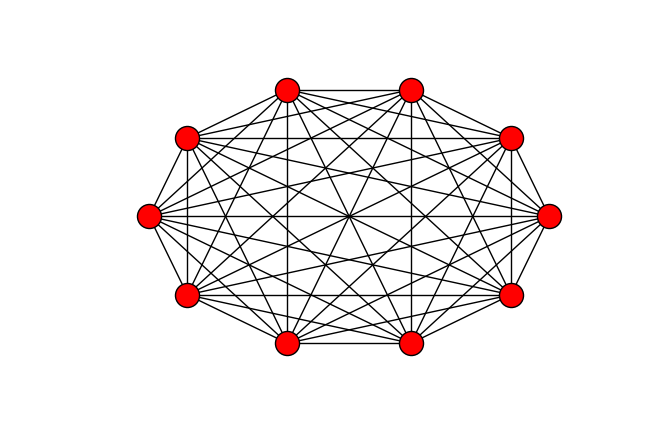

In [10]:
G = nx.complete_graph(10)
nx.draw_circular(G)
plt.show()

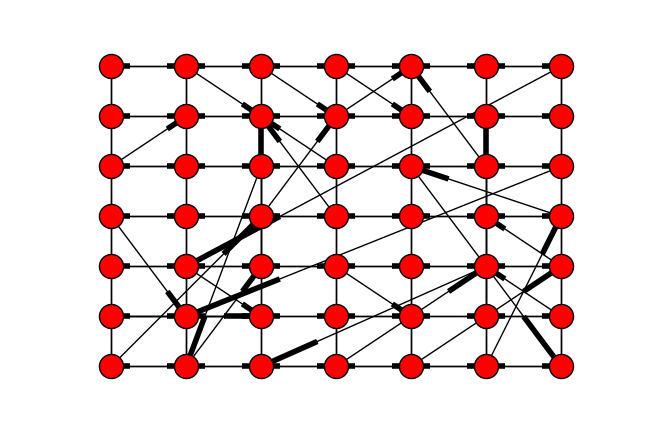

In [38]:
G = nx.navigable_small_world_graph(7, p=1, q=1, r=2, dim=2)
#nx.draw_networkx(G, pos=dict(zip(G,G)))
nx.draw(G, pos=dict(zip(G,G)))
plt.show()

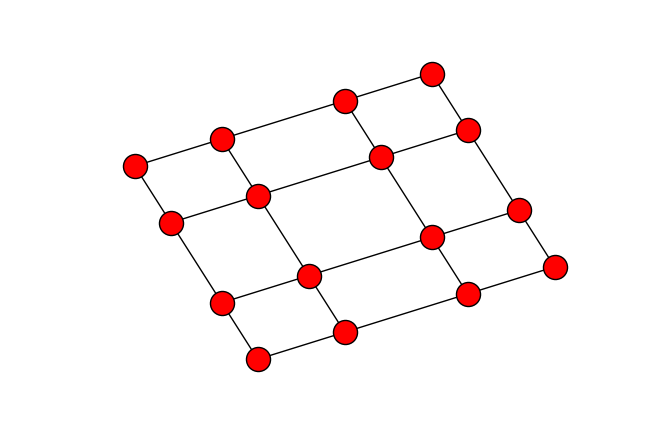

In [12]:
G = nx.grid_2d_graph(4,4)
nx.draw_spectral(G)
plt.show()

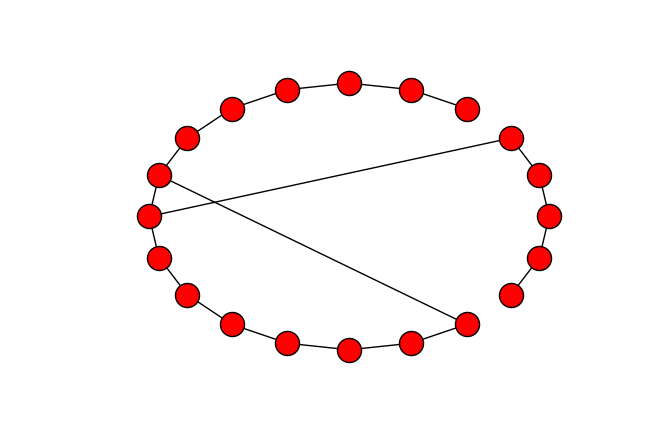

In [13]:
G = nx.watts_strogatz_graph(20, 3, 0.1)
nx.draw_circular(G)
plt.show()

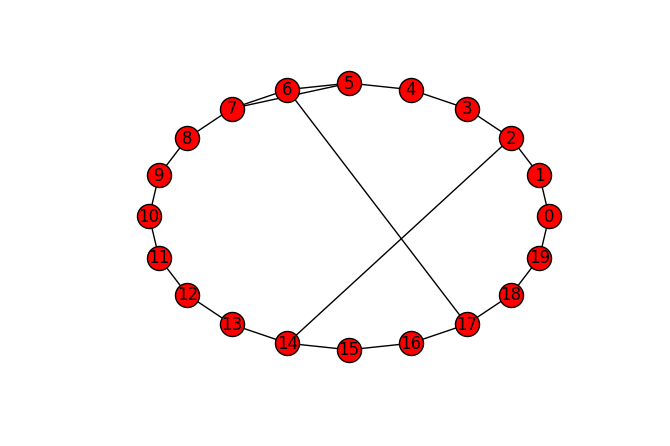

[1, 2, 14, 13, 12, 11, 10]

In [14]:
G = nx.newman_watts_strogatz_graph(20, 3, 0.3)
nx.draw_circular(G, with_labels=True)
plt.show()
G.nodes()
nx.shortest_path(G, 1, 10)



In [15]:
# Use graphviz
G = nx.complete_graph(10)
A = nx.nx_agraph.to_agraph(G)
A.layout()
# prog=[neato, dot, twopi, circo, fdp, nop, wc, acyclic, gvpr, gvcolor, ccomps, sccmap, tred, sfdp.]
A.draw('graph.ps', prog='circo')

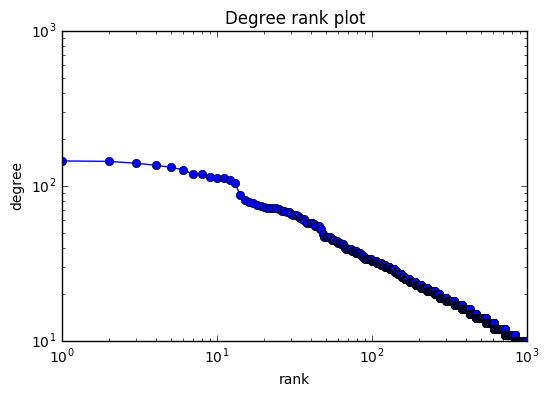

In [16]:
G=nx.Graph()
G = nx.barabasi_albert_graph(1000, 10)
#nx.draw_circular(G, with_labels=True, node_size=200)
#plt.show()

degree_sequence=sorted(nx.degree(G).values(),reverse=True)
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

Greedy Routing
==================

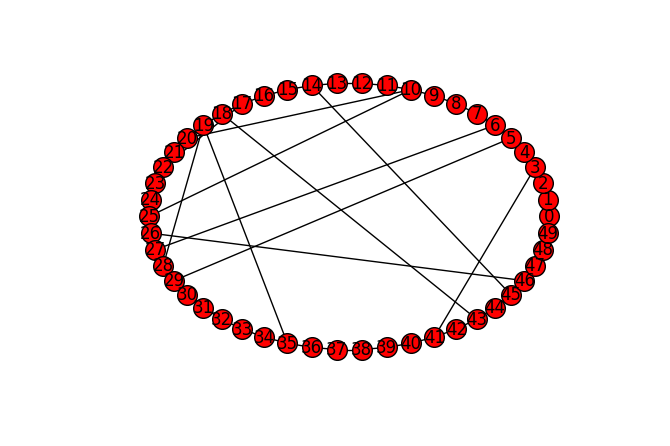

In [17]:
G = nx.newman_watts_strogatz_graph(50, 3, 0.3)
nx.draw_circular(G, with_labels=True, node_size=200)
plt.show()

Kleinberg's Model with Ring topology
====================================

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
from math import log
import random, logging, sys

import networkx as nx
import matplotlib.pyplot as plt

from utils.gen import kleinberg_ring
from utils.search import greedy_path, average_greedy_path_length, RoutingError
from utils.misc import shuffle_position_ring, dist_ring, labels_from_attr

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, stream=sys.stderr)

1. Good
-------------------------------
### 1.1 Generate Kleinberg ring

In [7]:
k = 1
n = int(1000*(2**k))
n = 100
max_step = int(log(n, 2)*log(n, 2))
out_deg = 3*int(log(n, 2))
#out_deg = 1
print("n=%s, max step=%s, out deg=%s" % (n, max_step, out_deg))

G = kleinberg_ring(n, p=0, q=out_deg, r=1)

print("CC=%s" % nx.average_clustering(G))

n=100, max step=44, out deg=18
CC=0.2967923009436505


#### Fig. 1

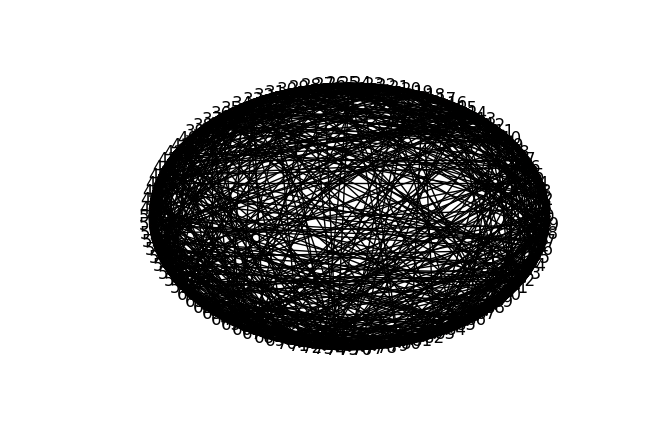

In [8]:
nx.draw_circular(G, with_labels=True, node_size=1)
#plt.figure(1, figsize=(50,50))
plt.show()

### 1.2 Routing test

In [10]:
logging.root.setLevel(logging.INFO)
apl, srate = average_greedy_path_length(G, cutoff=max_step)
print("average path length = %s" % apl)
print("success rate = %s" % srate)
logger.debug("poo")
#s_path = nx.shortest_path(G, 0, n//2)
#print("ideal path length is %d" % (len(s_path) - 1))

average path length = 1.9501002004008017
success rate = 0.998


2. Shuffle
-------------

### 2.1 Shuffle Good graph

In [11]:
G_s, labels = shuffle_position_ring(G, iteration=1000)

#### Fig. 2

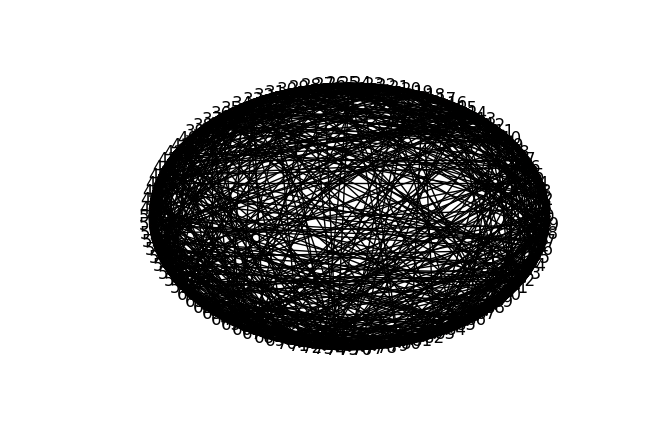

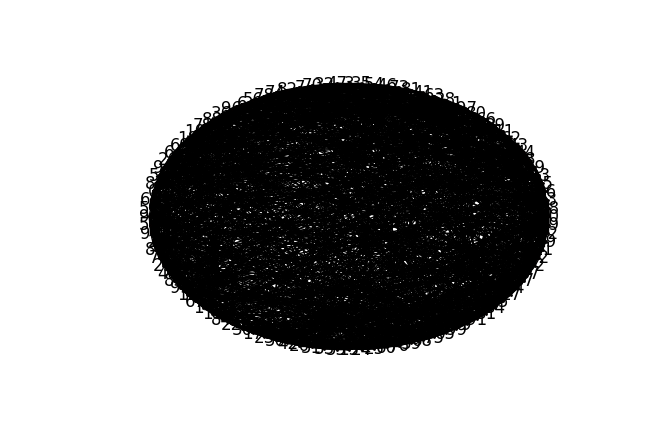

In [12]:
nx.draw_circular(G, with_labels=True, node_size=1, label='Start')
plt.show()
nx.draw_circular(G_s, with_labels=True, node_size=1, labels=labels)
plt.show()

### 2.2 Routing Test

In [13]:
logging.root.setLevel(logging.INFO)
apl, srate = average_greedy_path_length(G_s, cutoff=max_step)
print("average path length = %s" % apl)
print("success rate = %s" % srate)

average path length = 1.539761207479162
success rate = 0.4439


3. Restore
---------------
### 3.1 Metropolis-Hastings

In [14]:
mcs = 6000*n
mcs = 500000
print("running %d mcs..." % mcs)
for nd in G_s.nodes():
    G_s.node[nd]['original-sh'] = nd
G_r = G_s.copy()
phi = dict((x, x) for x in G_r.nodes())

def distance_prod(G, x, y, switched=False):
    size = G.number_of_nodes()
    prod = 1.0
    #print("neighbors=%s" % G.neighbors(x))
    #print("neighbors=%s" % G.neighbors(y))
    if not switched:
        for ngh in G.neighbors(x):
            prod *= dist_ring(x,ngh,size)
        for ngh in G.neighbors(y):
            prod *= dist_ring(y,ngh,size)
    else:
        for ngh in G.neighbors(x):
            if ngh == y:
                continue
            prod *= dist_ring(y,ngh,size)
        for ngh in G.neighbors(y):
            if ngh == x:
                continue
            prod *= dist_ring(x,ngh,size)
    
    return prod

for i in range(0, mcs):
        if i % 1000 == 0:
            logging.info("reached %d" % i)
        x = int(random.uniform(0,n))
        y = int(random.uniform(0,n))
        #print("trying x-y switch: (%s,%s)" % (x,y))
        acceptance = min(1.0, distance_prod(G_r, x,y)/distance_prod(G_r,x,y,switched=True))
        #print("acceptance=%s" % acceptance)
        if random.uniform(0,1) < acceptance:
            #print("switching %d and %d" % (x,y))
            G_r = nx.relabel_nodes(G_r, {x:y,y:x})
            phi[x] = y
            phi[y] = x
        else:
            #print("rejected switching %d and %d" % (x,y))
            pass

INFO:root:reached 0


running 500000 mcs...


INFO:root:reached 1000
INFO:root:reached 2000
INFO:root:reached 3000
INFO:root:reached 4000
INFO:root:reached 5000
INFO:root:reached 6000
INFO:root:reached 7000
INFO:root:reached 8000
INFO:root:reached 9000
INFO:root:reached 10000
INFO:root:reached 11000
INFO:root:reached 12000
INFO:root:reached 13000
INFO:root:reached 14000
INFO:root:reached 15000
INFO:root:reached 16000
INFO:root:reached 17000
INFO:root:reached 18000
INFO:root:reached 19000
INFO:root:reached 20000
INFO:root:reached 21000
INFO:root:reached 22000
INFO:root:reached 23000
INFO:root:reached 24000
INFO:root:reached 25000
INFO:root:reached 26000
INFO:root:reached 27000
INFO:root:reached 28000
INFO:root:reached 29000
INFO:root:reached 30000
INFO:root:reached 31000
INFO:root:reached 32000
INFO:root:reached 33000
INFO:root:reached 34000
INFO:root:reached 35000
INFO:root:reached 36000
INFO:root:reached 37000
INFO:root:reached 38000
INFO:root:reached 39000
INFO:root:reached 40000
INFO:root:reached 41000
INFO:root:reached 42000
I

#### Fig. 3

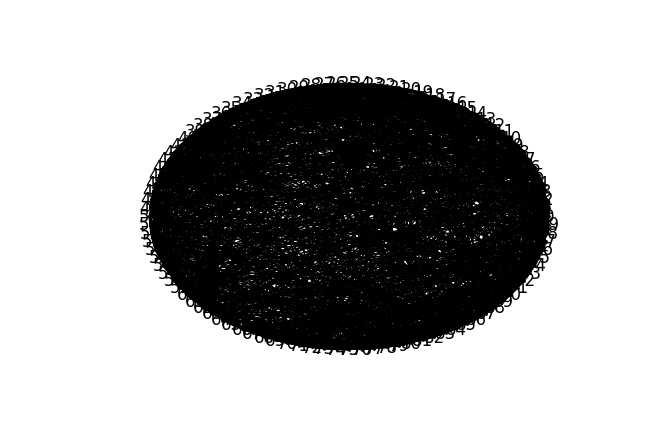

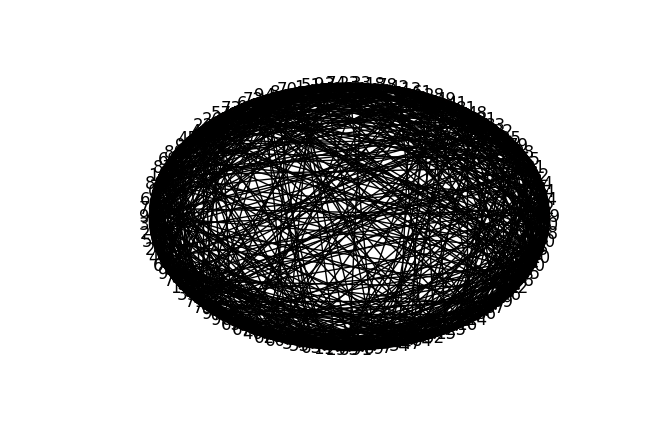

In [15]:
nx.draw_circular(G_s, with_labels=True, node_size=1)
plt.show()
nx.draw_circular(G_r, with_labels=True, node_size=1, labels=dict((n,d['original-sh']) for n,d in G_r.nodes(data=True)))
plt.show()

### 3.2 Routing Test
#### 3.2.1 Fail

In [16]:
logging.root.setLevel(logging.INFO)
apl, srate = average_greedy_path_length(G_r, cutoff=max_step)
print("average path length = %s" % apl)
print("success rate = %s" % srate)

average path length = 1.9345346715328466
success rate = 0.8768


#### 3.2.2 Local Contact

In [17]:
logging.root.setLevel(logging.INFO)
apl, srate = average_greedy_path_length(G_r, cutoff=max_step, use_local=True)
print("average path length = %s" % apl)
print("success rate = %s" % srate)

average path length = 1.9843
success rate = 1.0


#### 3.2.3 Continue

In [18]:
logging.root.setLevel(logging.INFO)
apl, srate = average_greedy_path_length(G_r, cutoff=max_step, strict=False)
print("average path length = %s" % apl)
print("success rate = %s" % srate)

average path length = 2.1918
success rate = 1.0


PGP to Kleinberg ring
========================

1. Preprocess PGP data
------------------

In [ ]:
dad

Routing debugging
===================

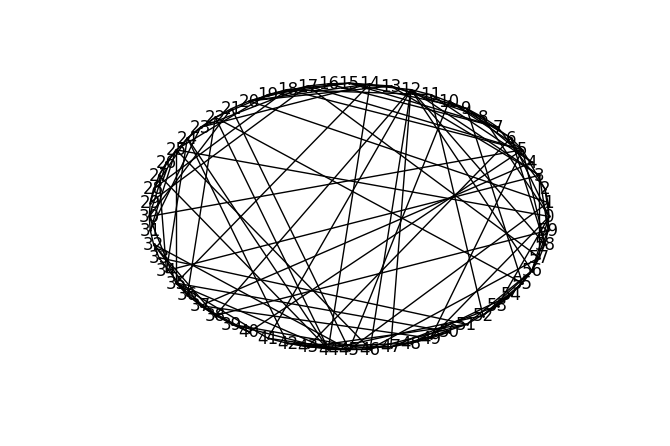

DEBUG:utils.search:current node is 0: d(0, 10)=10
DEBUG:utils.search:checking neighbor 49: d(49, 10)=21
DEBUG:utils.search:checking neighbor 2: d(2, 10)=8
DEBUG:utils.search:checking neighbor 53: d(53, 10)=17
DEBUG:utils.search:checking neighbor 6: d(6, 10)=4
DEBUG:utils.search:checking neighbor 56: d(56, 10)=14
DEBUG:utils.search:checking neighbor 8: d(8, 10)=2
DEBUG:utils.search:checking neighbor 25: d(25, 10)=15
DEBUG:utils.search:current node is 8: d(8, 10)=2
DEBUG:utils.search:checking neighbor 9: d(9, 10)=1
DEBUG:utils.search:checking neighbor 13: d(13, 10)=3
DEBUG:utils.search:checking neighbor 7: d(7, 10)=3
DEBUG:utils.search:current node is 9: d(9, 10)=1
DEBUG:utils.search:checking neighbor 4: d(4, 10)=6
DEBUG:utils.search:checking neighbor 6: d(6, 10)=4
DEBUG:utils.search:checking neighbor 55: d(55, 10)=15
DEBUG:utils.search:checking neighbor 11: d(11, 10)=1
DEBUG:utils.search:checking neighbor 13: d(13, 10)=3
DEBUG:utils.search:checking neighbor 15: d(15, 10)=5
DEBUG:utils.s

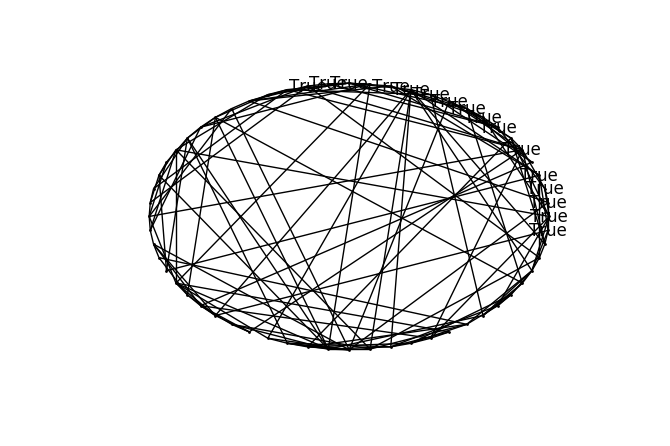

In [22]:
logging.root.setLevel(logging.DEBUG)
G = kleinberg_ring(60, p=0, q=3, r=1)
nx.draw_circular(G, with_labels=True, node_size=1)
plt.show()
path, labels, step = greedy_path(G, 0, 10, strict=False)
nx.draw_circular(G, with_labels=True, node_size=1, labels=labels)
plt.show()
